In [ ]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
import corner
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

## Lensed quasar population

This notebook shows how to simulate lensed quasar population.

In [6]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=500, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 30, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.001, "z_max": 5.0}

In [7]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [8]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:47: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:50: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [9]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

In [ ]:
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    point_source_type="quasar",  # can be supernova or
    point_source_kwargs=dict(
        variability_model=None,
        kwargs_variability_model=None,
        light_profile=None,
    ),
)

In [11]:
# Initiate LensPop class to generate lensed quasar pop. We simulate lens pop in 500
# deg^2. If you want to simulate in larger sky, change sky area to your requirement.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

In [12]:
sample_source = quasar_lens_pop._sources._point_source_select

## Draw lenses

In [16]:
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

## Extract necessary quantities of each lens

In [17]:
print("Number of lenses:", len(quasar_lens_population))

lens_samples2 = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]
source_z = []
deflector_z = []
sigma_v = []
m_s = []
for ps_lens in quasar_lens_population:
    source_mag = min(ps_lens.point_source_magnitude(band="i", lensed=True))
    vel_disp = ps_lens.deflector_velocity_dispersion()
    m_star = ps_lens.deflector_stellar_mass()
    theta_e = ps_lens.einstein_radius
    zl = ps_lens.deflector_redshift
    zs = ps_lens.source_redshift
    deflector_mag = ps_lens.deflector_magnitude(band="i")
    source_z.append(zs)
    deflector_z.append(zl)
    sigma_v.append(vel_disp)
    m_s.append(source_mag)
    lens_samples2.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 3404


## Plot lens quantities

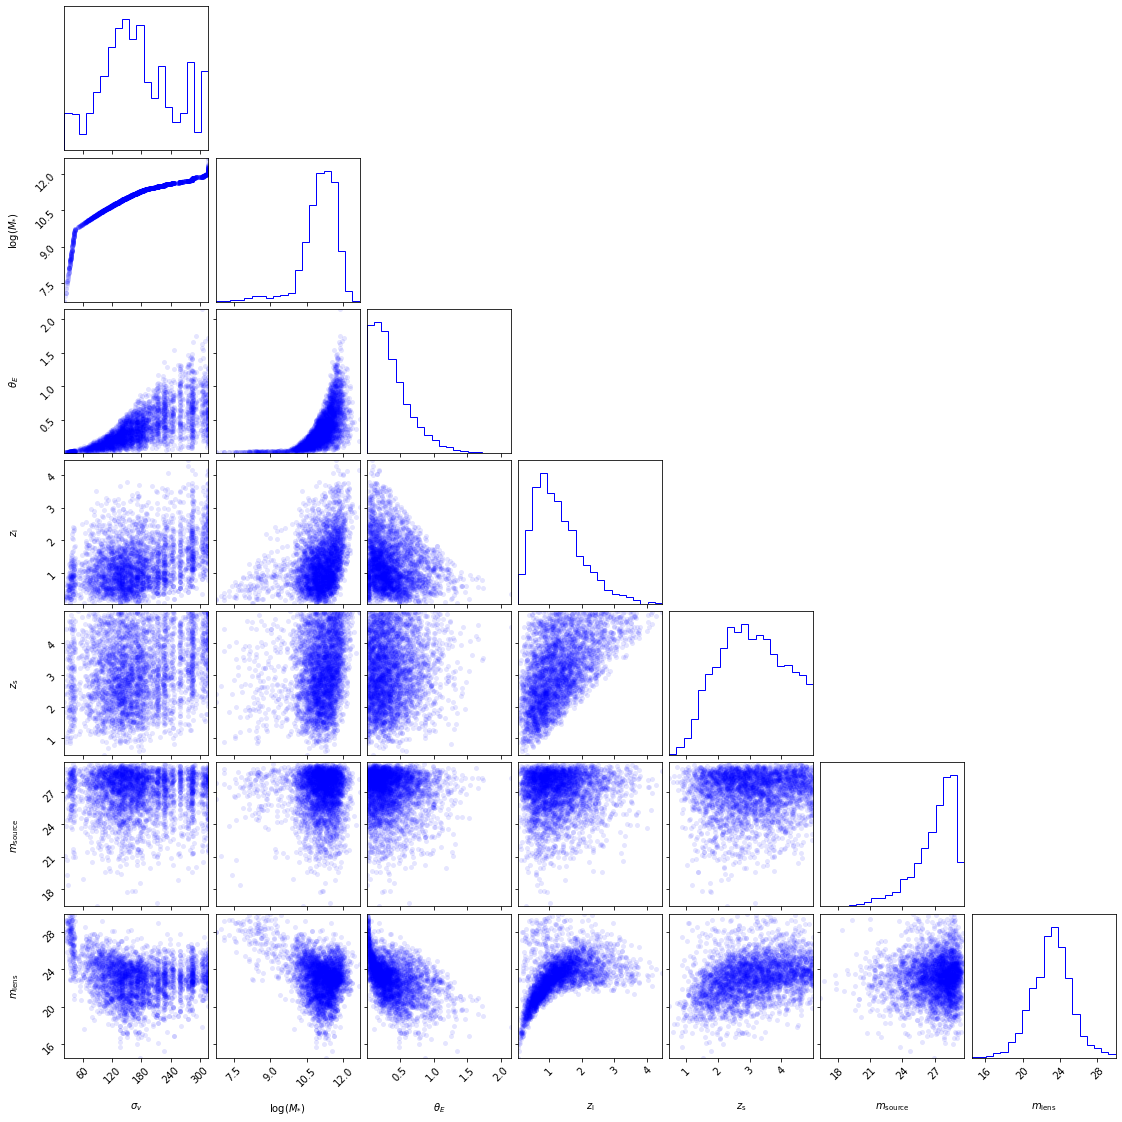

In [18]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples2), labels=labels, **hist2dkwargs)
plt.show()

## Apply some cuts

In [19]:
source_cut = []
deflector_cut = []
for i in range(len(source_z)):
    if m_s[i] <= 23.3:
        source_cut.append(source_z[i])
        deflector_cut.append(deflector_z[i])

In [22]:
source_cut_less_than_3 = []
for i in range(len(source_cut)):
    if source_cut[i] < 3:
        source_cut_less_than_3.append(source_cut[i])

In [37]:
number_of_lensed_quasar_in_full_LSST_survey_3 = (20000 / 500) * len(
    source_cut_less_than_3
)
number_of_lensed_quasar_in_full_LSST_survey_5 = (20000 / 500) * len(source_cut)
print(
    "Number of lensed quasar at redshift less than 3 is equal to",
    number_of_lensed_quasar_in_full_LSST_survey_3,
)
print(
    "Number of lensed quasar at redshift less than 5 is equal to",
    number_of_lensed_quasar_in_full_LSST_survey_5,
)

Number of lensed quasar at redshift less than 3 is equal to 5080.0
Number of lensed quasar at redshift less than 5 is equal to 8280.0


## Plot lensed source, unlensed source, and deflector distribution.

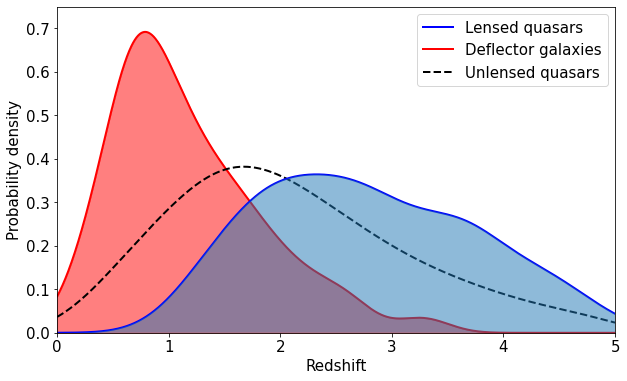

In [42]:
# Compute the KDE
kde_source = gaussian_kde(source_cut)
x_vals_source = np.linspace(0, 5, 1000)
kde_vals_source = kde_source(x_vals_source)
kde_deflector = gaussian_kde(deflector_cut)
x_vals_deflector = np.linspace(0, 5, 1000)
kde_vals_deflector = kde_deflector(x_vals_deflector)

kde_unlensed_supernovae = gaussian_kde(sample_source["z"], bw_method=0.3)
x_vals_unlensed_supernovae = np.linspace(0, 5, 1000)
kde_vals_unlensed_supernovae = kde_unlensed_supernovae(x_vals_unlensed_supernovae)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(
    x_vals_source,
    kde_vals_source,
    color="blue",
    lw=2,
    zorder=2,
    label=r"Lensed quasars",
)
plt.fill_between(x_vals_source, kde_vals_source, alpha=0.5, zorder=2)
plt.plot(
    x_vals_deflector,
    kde_vals_deflector,
    color="red",
    lw=2,
    zorder=1,
    label=r"Deflector galaxies",
)
plt.fill_between(x_vals_deflector, kde_vals_deflector, color="red", alpha=0.5, zorder=1)
plt.plot(
    x_vals_unlensed_supernovae,
    kde_vals_unlensed_supernovae,
    ls="--",
    color="black",
    lw=2,
    zorder=1,
    label=r"Unlensed quasars",
)
# plt.title('Probability Distribution of Redshift')
plt.xlabel("Redshift", fontsize=15)
plt.ylabel("Probability density", fontsize=15)
plt.xlim(0, 5)
plt.ylim(0, 0.75)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()